In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Load the dataset
file_path = 'C:\\Users\\91964\\Desktop\\csp\\customer_support_tickets.csv'
df = pd.read_csv(file_path)

In [4]:
# Display dataset information
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Customer Age                  8469 non-null   int64 
 1   Customer Gender               8469 non-null   int64 
 2   Product Purchased             8469 non-null   object
 3   Ticket Type                   8469 non-null   object
 4   Ticket Status                 8469 non-null   int64 
 5   Ticket Priority               8469 non-null   int64 
 6   Ticket Channel                8469 non-null   object
 7   Viewed Ticket                 8469 non-null   int64 
 8   Ticket Solved                 8469 non-null   int64 
 9   Customer Satisfaction Rating  8469 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 661.8+ KB
None
   Customer Age  Customer Gender Product Purchased      Ticket Type  \
0            32                1        GoPro Hero  Technical issue  

In [5]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 Customer Age                    0
Customer Gender                 0
Product Purchased               0
Ticket Type                     0
Ticket Status                   0
Ticket Priority                 0
Ticket Channel                  0
Viewed Ticket                   0
Ticket Solved                   0
Customer Satisfaction Rating    0
dtype: int64


In [6]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
categorical_columns = ['Product Purchased', 'Ticket Type', 'Ticket Channel']
df[categorical_columns] = imputer.fit_transform(df[categorical_columns])

In [7]:
# Convert categorical variables to numerical using Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
# Define features and target variable
X = df.drop('Customer Satisfaction Rating', axis=1)
y = df['Customer Satisfaction Rating']

In [9]:
# Split the data into training and testing sets using Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
# Initialize the Balanced Random Forest model
model = BalancedRandomForestClassifier(random_state=42)

In [11]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=BalancedRandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [12]:
# Best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=10, min_samples_leaf=4,
                               min_samples_split=10, n_estimators=200,
                               random_state=42)

In [13]:
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7331759149940968
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1140
           1       0.24      0.26      0.25       111
           2       0.16      0.15      0.16       110
           3       0.17      0.16      0.16       116
           4       0.15      0.16      0.15       108
           5       0.20      0.19      0.20       109

    accuracy                           0.73      1694
   macro avg       0.32      0.32      0.32      1694
weighted avg       0.73      0.73      0.73      1694



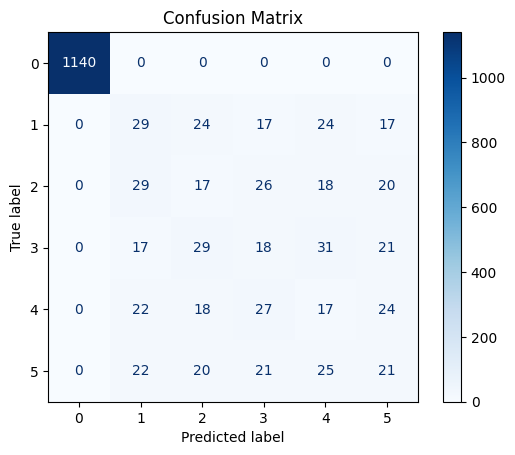

In [14]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

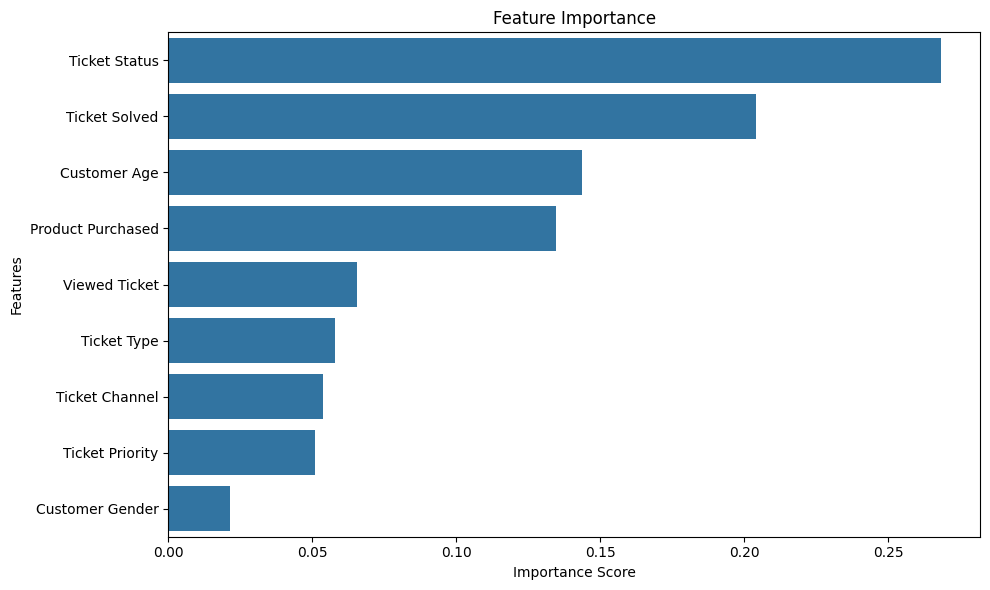

In [15]:
# 2. Feature Importance
importances = best_model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

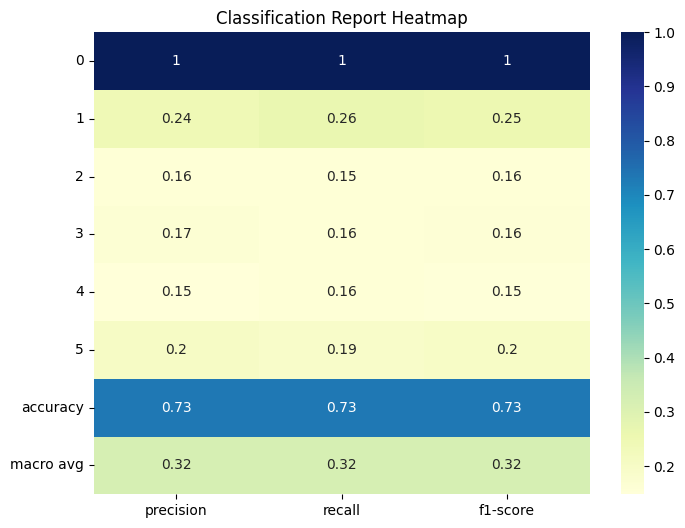

In [16]:
# 3. Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()

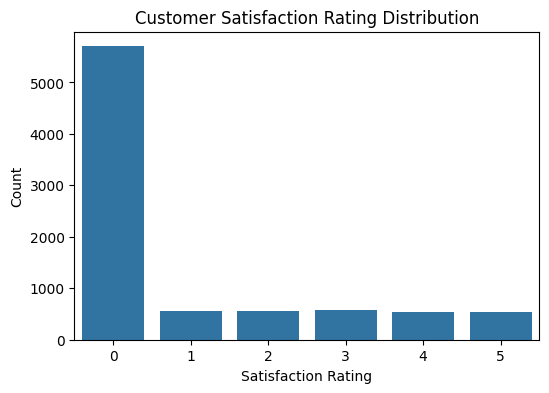

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Customer Satisfaction Rating Distribution')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Count')
plt.show()

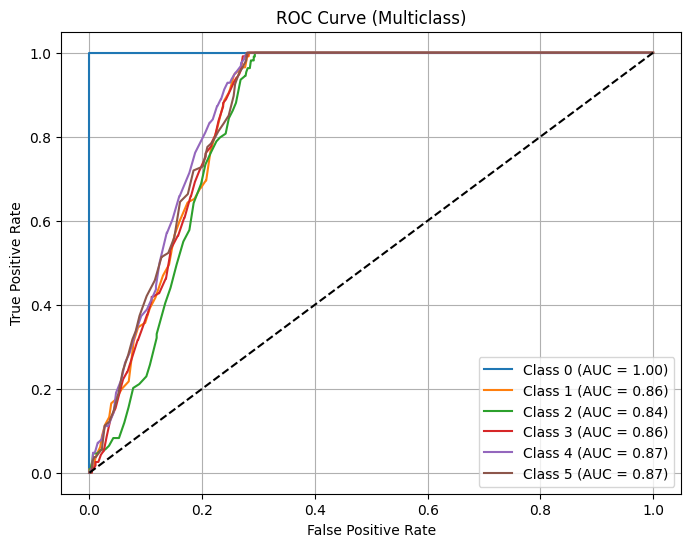

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Binarize the output
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Fit model
ovr_model = OneVsRestClassifier(BalancedRandomForestClassifier())
ovr_model.fit(X_train_bin, y_train_bin)
y_score = ovr_model.predict_proba(X_test_bin)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Multiclass)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


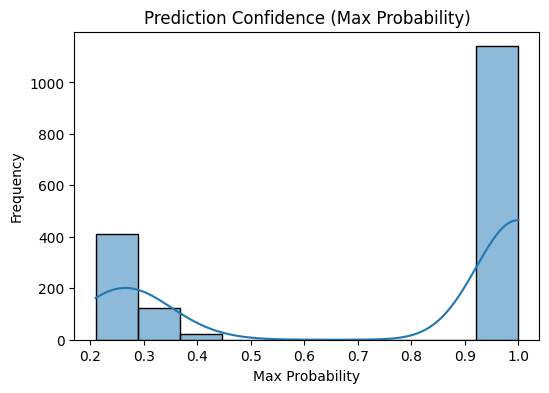

In [19]:
y_proba = best_model.predict_proba(X_test)
max_probs = y_proba.max(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(max_probs, bins=10, kde=True)
plt.title("Prediction Confidence (Max Probability)")
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.show()


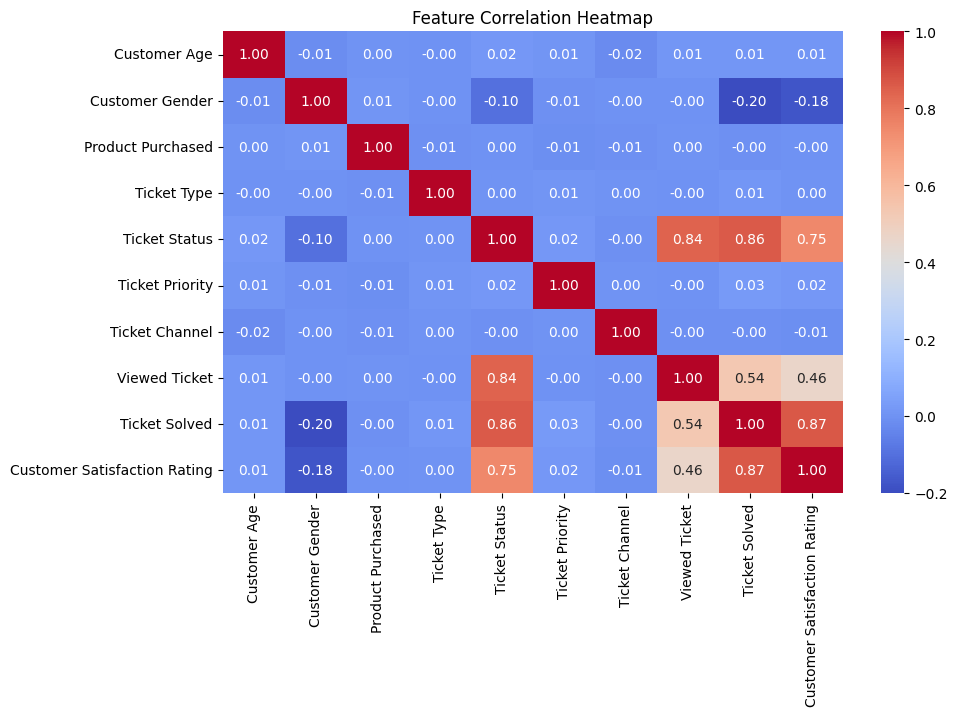

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


<Figure size 800x600 with 0 Axes>

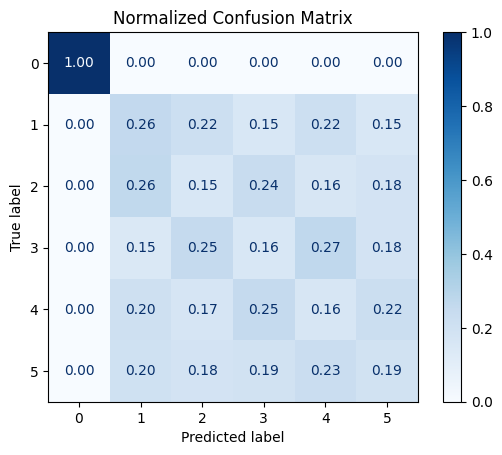

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred = best_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()


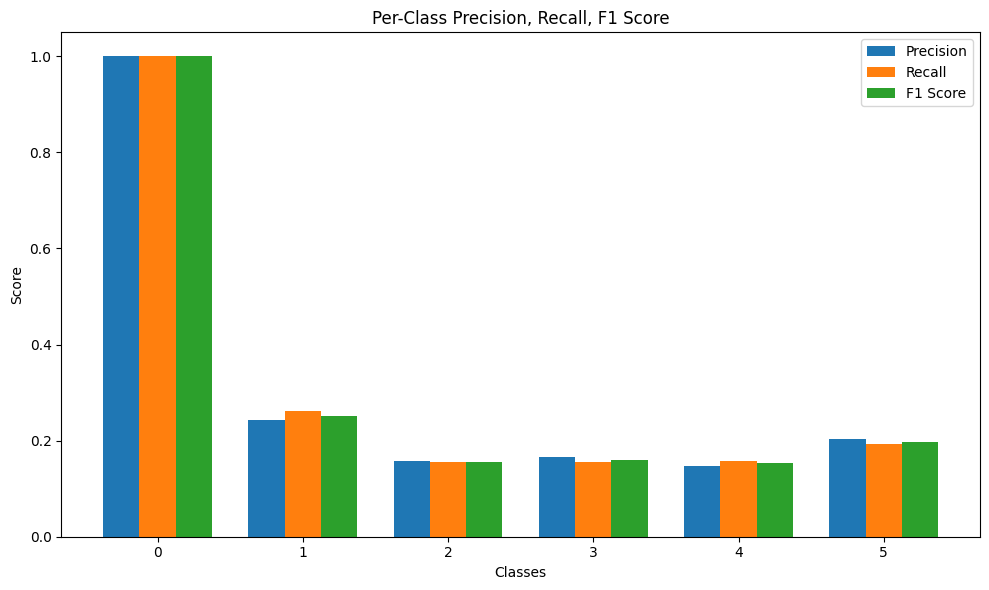

In [23]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Get scores
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=best_model.classes_)

# Plot
x = np.arange(len(best_model.classes_))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xticks(x, best_model.classes_)
plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1 Score")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# Add predictions to test set for inspection
results_df = X_test.copy()
results_df['True_Label'] = y_test.values
results_df['Predicted_Label'] = y_pred

# Show mismatches
misclassified = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print(misclassified.head(10))  # Show first 10 misclassified samples


      Customer Age  Customer Gender  Product Purchased  Ticket Type  \
1185            54                1                 40            0   
8434            50                1                 16            4   
7115            45                0                 16            4   
6274            62                0                 20            0   
7608            23                0                 29            4   
2766            31                1                 20            2   
1060            52                1                 27            2   
4035            61                0                 23            4   
7096            20                0                 27            4   
763             25                1                 38            2   

      Ticket Status  Ticket Priority  Ticket Channel  Viewed Ticket  \
1185              2                2               0              1   
8434              2                3               1              1   
7115 

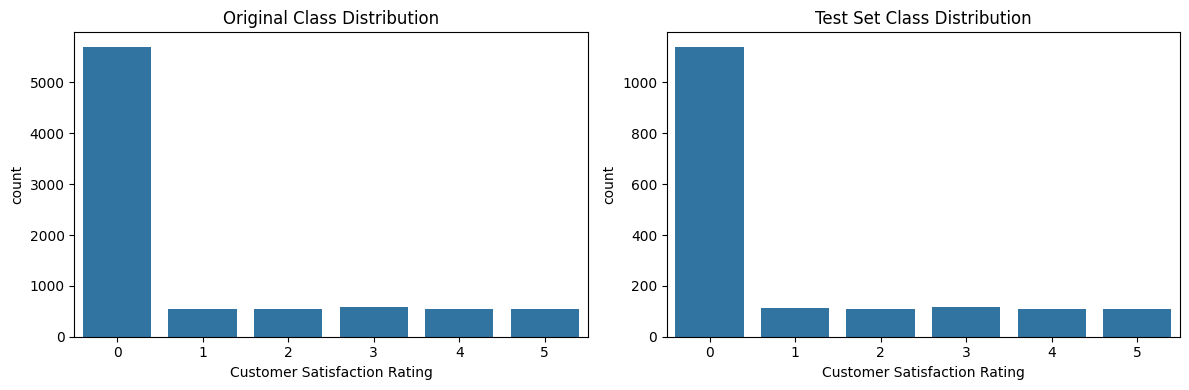

In [25]:
import seaborn as sns

# Original
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")

# After train-test split
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title("Test Set Class Distribution")
plt.tight_layout()
plt.show()


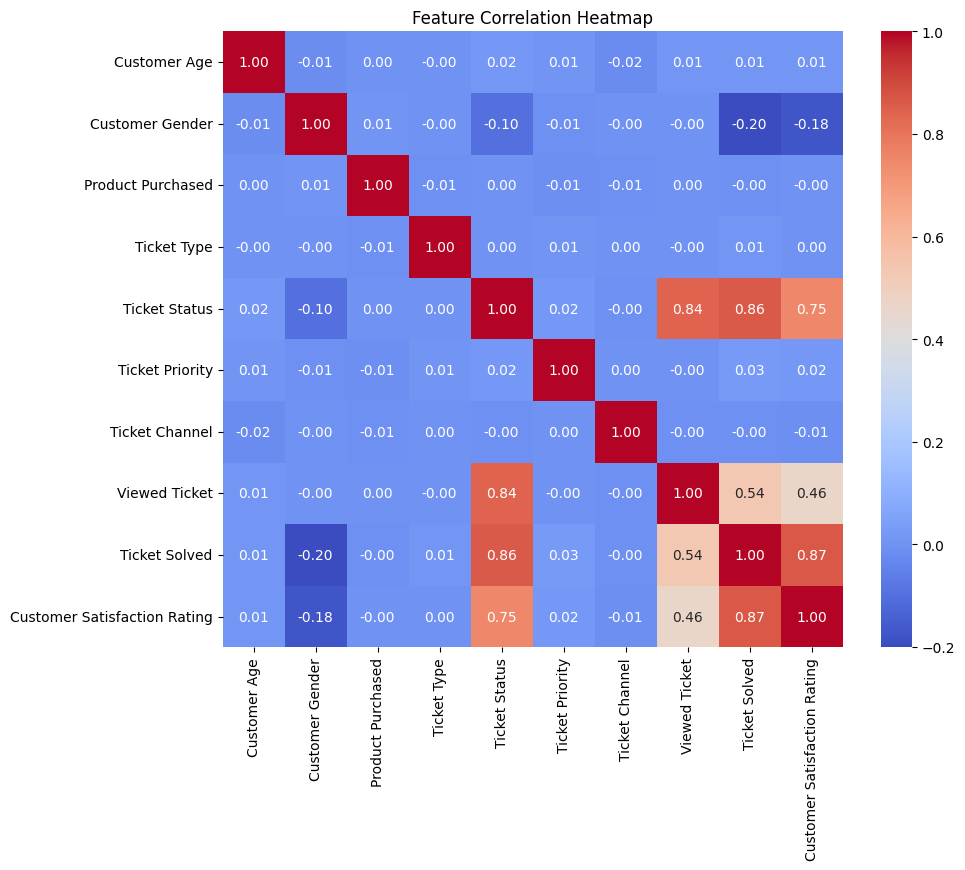

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


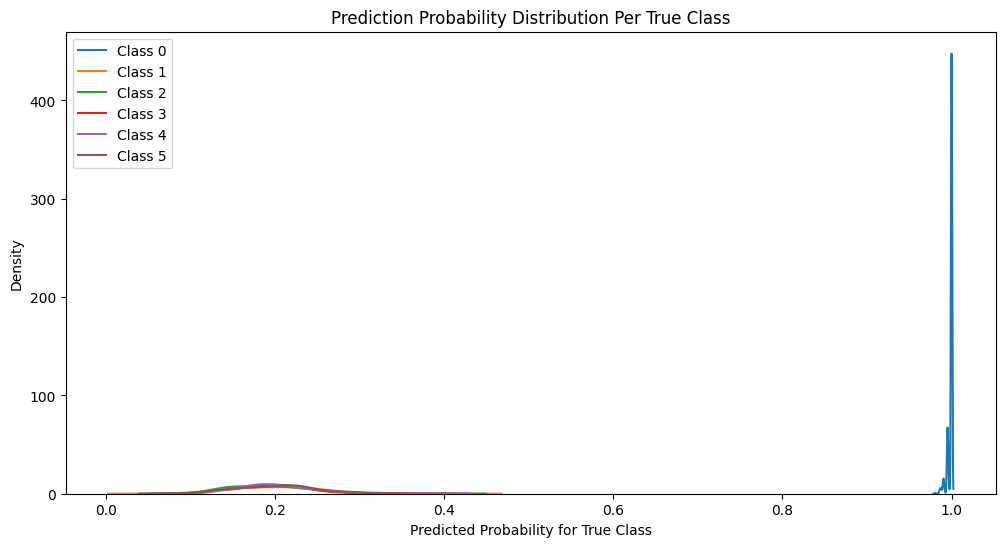

In [27]:
import numpy as np

# Get prediction probabilities
y_proba = best_model.predict_proba(X_test)
y_test_array = y_test.values

# Plot
plt.figure(figsize=(12, 6))
for class_idx in np.unique(y_test_array):
    class_probs = y_proba[y_test_array == class_idx, class_idx]
    sns.kdeplot(class_probs, label=f"Class {class_idx}")

plt.title("Prediction Probability Distribution Per True Class")
plt.xlabel("Predicted Probability for True Class")
plt.ylabel("Density")
plt.legend()
plt.show()


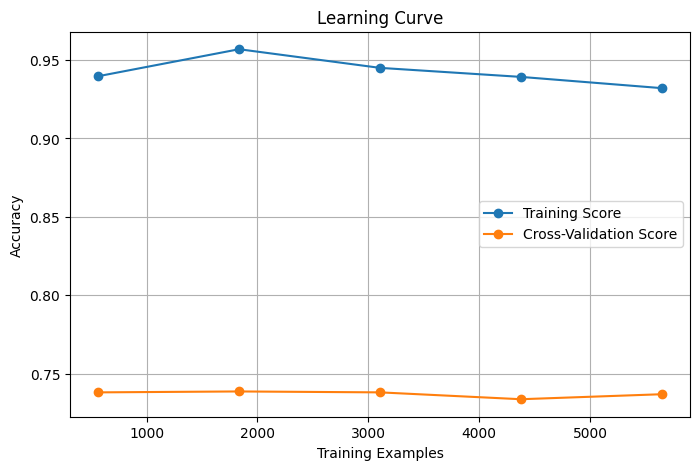

In [28]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=3, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
